In [1]:
import os
import time
import numpy as np
import pandas as pd
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor

# Utils

In [2]:
import polars as pl
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler 

class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=128):
        if offset < label_size:
            print(f"Offset will be changed from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size
        self.scaler = MinMaxScaler()
        self.list_days = []

        # Load the data
        self.df = pd.read_excel(file_path)
        for col in self.df.columns[1:]:
            # Extract values of the column and reshape for scaler input
            values = self.df[col].values.reshape(-1, 1)
    
            # Fit and transform the data using MinMaxScaler
            scaled_values = self.scaler.fit_transform(values)
    
            # Update the column in the DataFrame with scaled values
            self.df[col] = scaled_values.flatten()

        self.df = pl.DataFrame(self.df)
        
        self.list_days = self.df['Date'].to_numpy().reshape(-1, 1)

        if date_column is not None:
           self.df = self.df.drop(date_column)

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train, _, _ = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape = }')
        print(f'{self.y_train.shape = }')
        self.X_val, self.y_val, _, _ = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape = }')
        print(f'{self.y_val.shape = }')
        self.X_test, self.y_test, self.s_id, self.e_id = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape = }')
        print(f'{self.y_test.shape = }')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def fit(self):
        df = pl.read_excel(file_path)
        close_values = df.select('vnindex_Close').to_numpy()
        fited = self.scaler.fit(close_values)
        return fited

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns

        return np.array(features), np.array(labels), start_idx, end_idx

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).cuda()
        y_tensor = torch.tensor(y, dtype=torch.float32).cuda()
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)


In [3]:
import torch
import torch.nn as nn

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model.cuda() if torch.cuda.is_available() else model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)

        return predictions

    def plot(self, date, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[-num_elements:]
            yhat = yhat[-num_elements:]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(date, y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(date, yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel(f'Last {num_elements} records.')
            plt.ylabel('Values')
            plt.legend()

            plt.xticks(date.flatten(), rotation=45, fontsize=10)

            if save_plots:
                # Create the save directory if it doesn't exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images

class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')

    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_squared_error
        # print(self.preprocessing(y).shape)
        # print(self.predict(self.preprocessing(x)).shape)
        return mean_squared_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

# Models

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)  # Adjust for output sequence length
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, lag * features]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)#, dropout=0.2)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [7]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)#, dropout=0.2)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


# Configs

In [8]:
input_size = 15
label_size = 1
offset = 1
train_size = 0.8
val_size = 0.1
num_epochs = 1_000_000
patience = 50
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 180
target_name = 'vnindex_Close'
date_column = 'Date'
file_path = 'C:\\Users\\Admin\\AIO\\Multivariate Time Series Forecasting (LSTM)\\vnindex_bit.xlsx'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

In [9]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.01,
    'early_stopping_rounds': patience
}

# EDA

In [10]:
train_df = pl.read_excel(file_path)

In [11]:
train_df.describe()

statistic,Date,vnindex_Close,vnindex_Volume,bit_Close,bit_Volume
str,str,f64,f64,f64,f64
"""count""","""2169""",2169.0,2169.0,2169.0,2169.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,921.275219,3.0459e8,13370.349399,1.7530e10
"""std""",null,264.415851,2.4533e8,15979.746153,2.0747e10
"""min""","""2014-09-18 00:00:00""",518.22,5.367676e7,178.102997,7.84588e6
"""25%""",null,674.57,1.2379381e8,740.828979,1.30476e8
"""50%""",null,943.11,1.8454947e8,7493.48877,1.0174e10
"""75%""",null,1062.26,4.74920831e8,19413.550781,3.0006e10
"""max""","""2023-05-26 00:00:00""",1528.5699,1.4522e9,67566.828125,3.5097e11


In [12]:
import polars as pl
pl.Config.set_tbl_cols(100)
summary_df = []

for column_name in train_df.columns:
    col = train_df[column_name]

    dtype = str(col.dtype)
    missing_values = col.is_null().sum()
    missing_ratio = missing_values / len(train_df)
    unique_values = col.n_unique()
    unique_ratio = unique_values / len(train_df)

    # Get the most frequent value and its count
    value_counts = col.value_counts()
    most_freq_value_index = value_counts[column_name][0]
    most_freq_value_count = value_counts["count"][0]
    most_freq_value_ratio = most_freq_value_count / len(train_df)

    summary_row = {
        'Name': column_name,
        'DType': dtype,
        'MissingValues': missing_values,
        'MissingValuesRatio': missing_ratio,
        'UniqueValues': unique_values,
        'UniqueValuesRatio': unique_ratio,
        'MostFreqValue': most_freq_value_index,
        'MostFreqValueCount': most_freq_value_count,
        'MostFreqValueCountRatio': most_freq_value_ratio
    }

    summary_df.append(summary_row)

print(pl.from_dicts(summary_df))


shape: (5, 9)
┌─────────────┬─────────┬─────────────┬─────────────┬─────────────┬─────────────┬────────────┬────────────┬────────────┐
│ Name        ┆ DType   ┆ MissingValu ┆ MissingValu ┆ UniqueValue ┆ UniqueValue ┆ MostFreqVa ┆ MostFreqVa ┆ MostFreqVa │
│ ---         ┆ ---     ┆ es          ┆ esRatio     ┆ s           ┆ sRatio      ┆ lue        ┆ lueCount   ┆ lueCountRa │
│ str         ┆ str     ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ tio        │
│             ┆         ┆ i64         ┆ f64         ┆ i64         ┆ f64         ┆ str        ┆ i64        ┆ ---        │
│             ┆         ┆             ┆             ┆             ┆             ┆            ┆            ┆ f64        │
╞═════════════╪═════════╪═════════════╪═════════════╪═════════════╪═════════════╪════════════╪════════════╪════════════╡
│ Date        ┆ String  ┆ 0           ┆ 0.0         ┆ 2169        ┆ 1.0         ┆ 2015-04-06 ┆ 1          ┆ 0.000461   │
│             ┆   

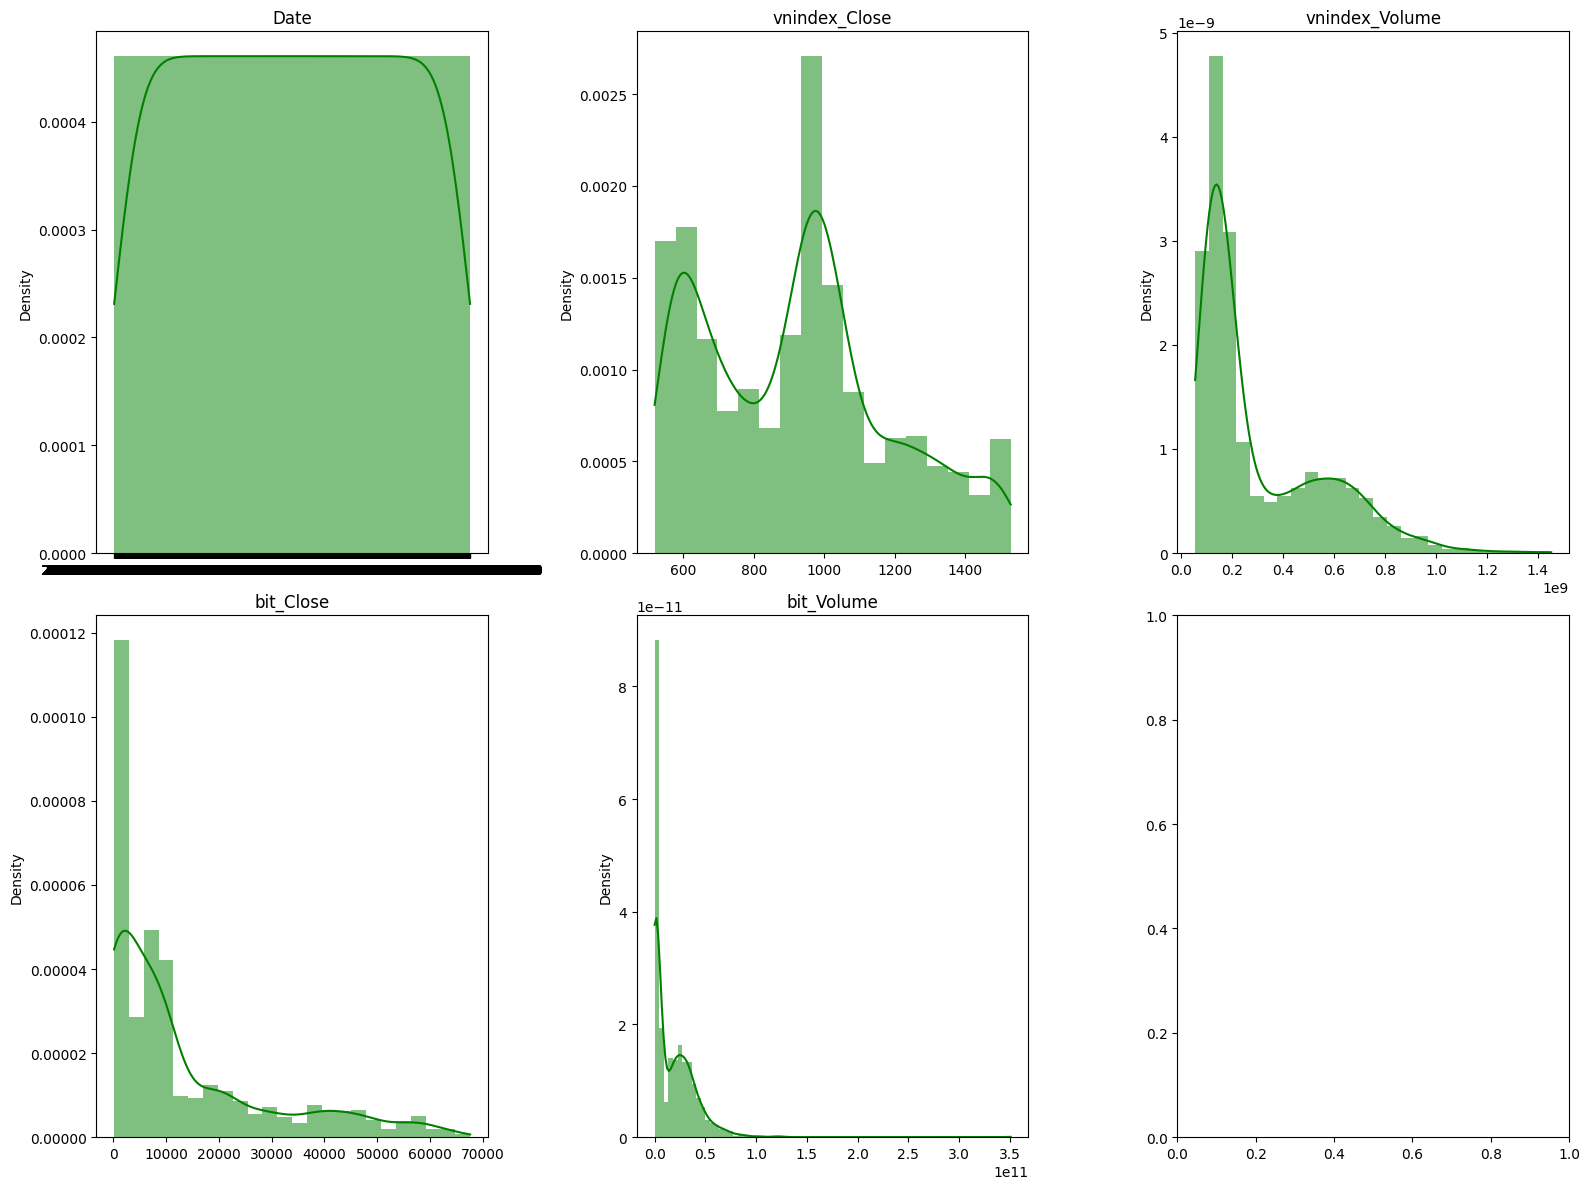

In [13]:
columns_to_plot = train_df.columns

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(train_df[column], kde=True, ax=axes[i],
                 color='green', stat="density", linewidth=0)
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

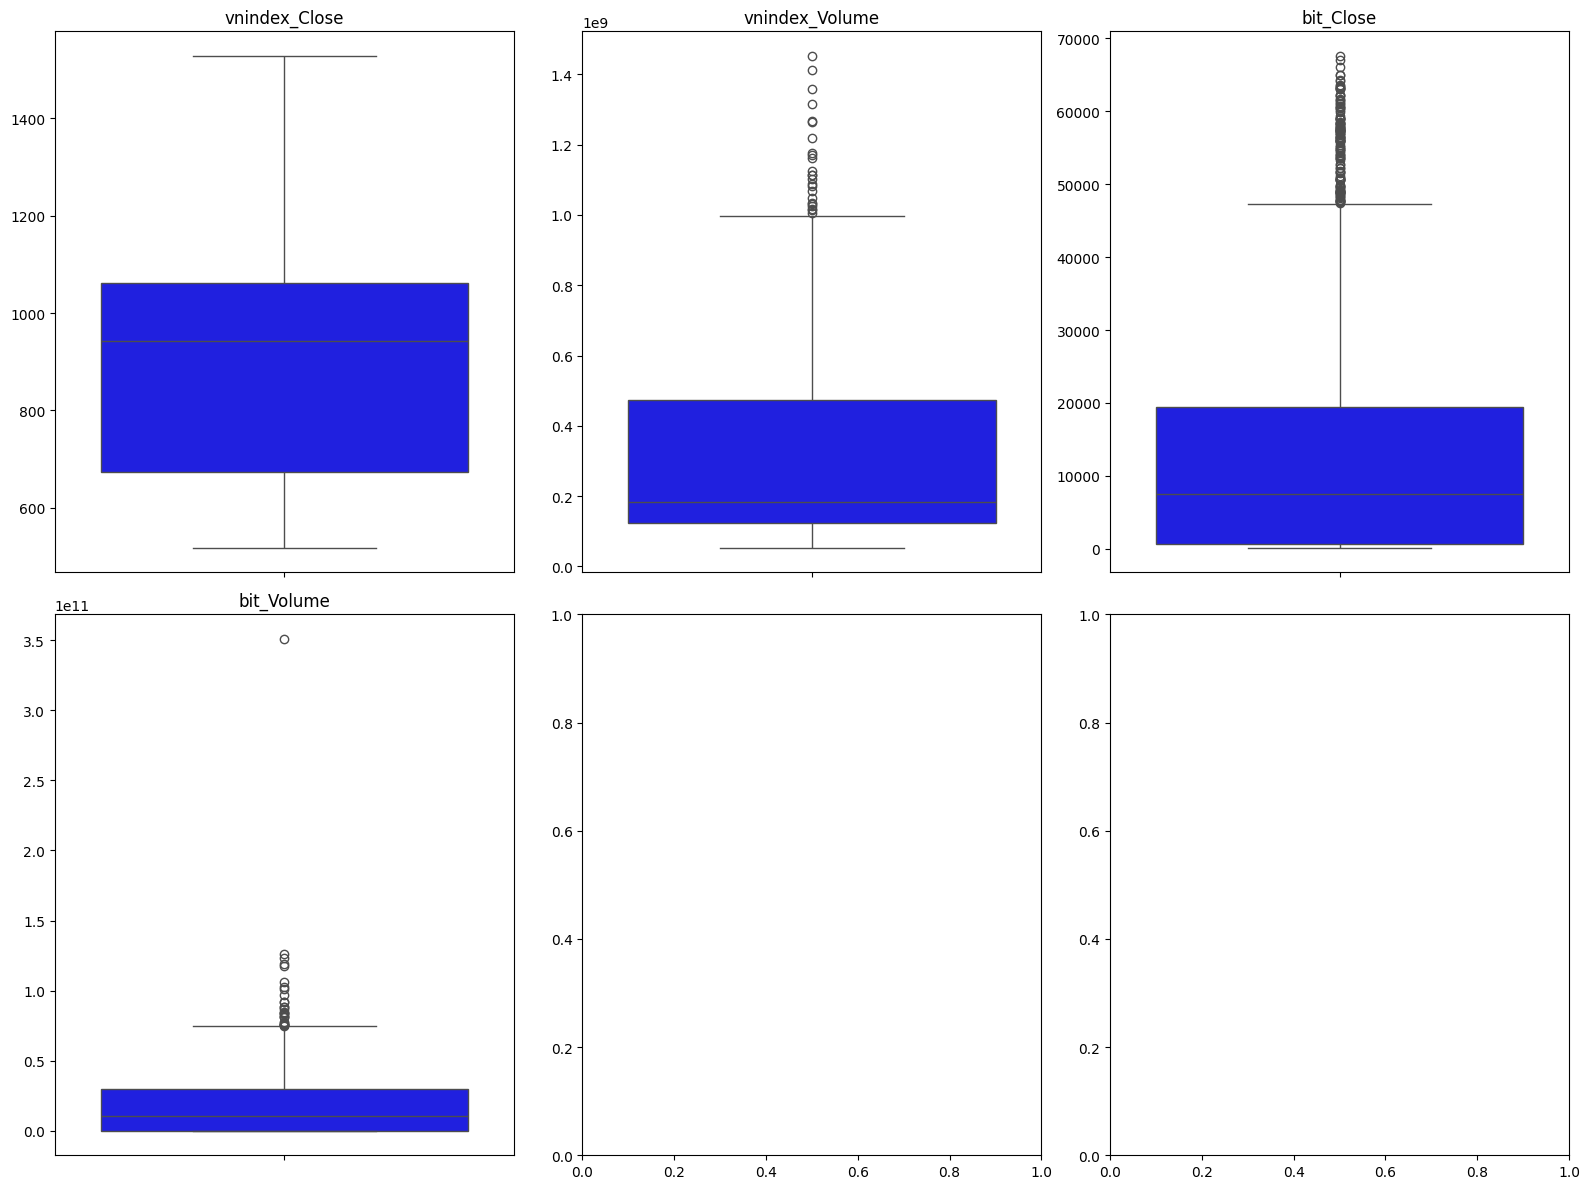

In [14]:
columns_to_plot = [c for c in train_df.columns if c != date_column]

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=train_df[column], ax=axes[i], color='blue')
    axes[i].set_title(column)


plt.tight_layout()
plt.show()

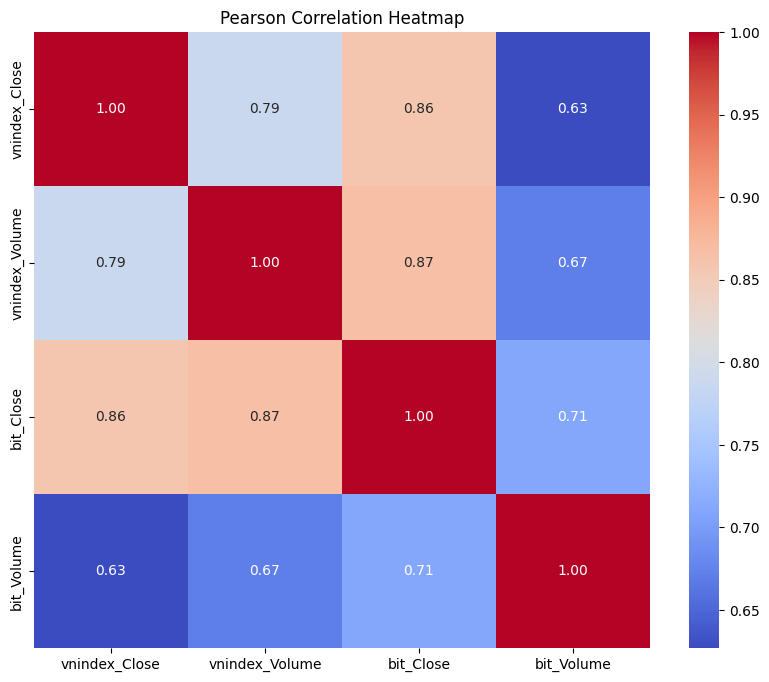

In [15]:
train = train_df[train_df.columns[1:]].to_pandas()
# print("dasdad")
pearson_corr = train.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, annot_kws={"size": 10})
plt.title('Pearson Correlation Heatmap')
plt.show()

# **Multivariate-to-Univartiate**

In [16]:
features_type='MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

self.X_train.shape = (1719, 15, 4)
self.y_train.shape = (1719, 1, 1)
self.X_val.shape = (201, 15, 4)
self.y_val.shape = (201, 1, 1)
self.X_test.shape = (199, 15, 4)
self.y_test.shape = (199, 1, 1)


In [17]:
inverse = multi2uni_loader.fit()
inverse

MinMaxScaler()

In [18]:
last_y_test = multi2uni_loader.y_test[-1]
last_y_test = inverse.inverse_transform(last_y_test)
df = pd.read_excel(file_path)
index = df[df['vnindex_Close'] == last_y_test[0][0]].index[0]

In [19]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2uni_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-LSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0775, val_loss: 0.1198
Epoch [2/1000000], time: 0s, loss: 0.0720, val_loss: 0.2063
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [3/1000000], time: 0s, loss: 0.0355, val_loss: 0.1185
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [4/1000000], time: 0s, loss: 0.0298, val_loss: 0.0513
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [5/1000000], time: 0s, loss: 0.0236, val_loss: 0.0124
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [6/1000000], time: 0s, loss: 0.0181, val_loss: 0.0043
Epoch [7/1000000], time: 0s, loss: 0.0260, val_loss: 0.0182
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [8/1000000], time: 0s, loss: 0.0136, val_loss: 0.0038
Epoch [9/1000000], time: 0s, loss: 0.0312, val_loss: 0.0462
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [10/1000000], time: 0s, loss: 0.0111, val_loss: 0.0023
Epoch [11/1000000], time: 0s, loss: 0.0235, val_loss: 0.0333
Model sav

{'Name': 'LSTM', 'Type': 'multi2uni', 'MSE': 0.0002193002583226189}

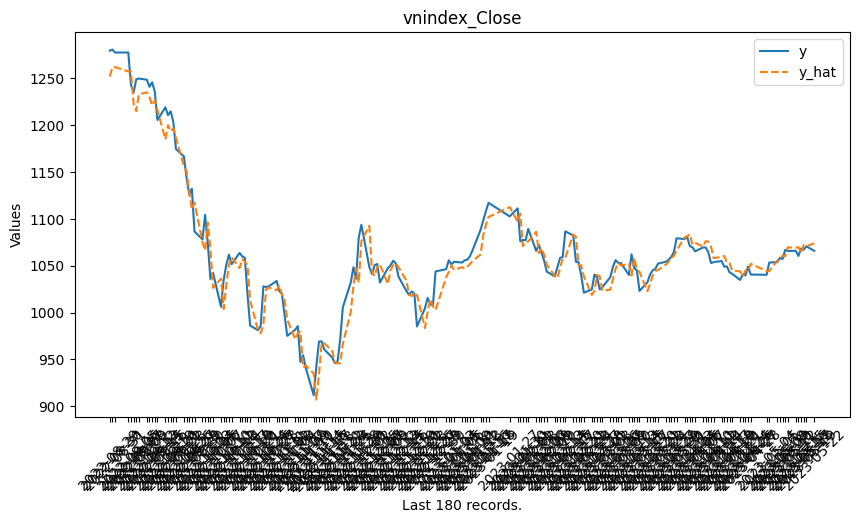

In [20]:
LSTM_multi2uni_manager.plot(multi2uni_loader.list_days[(index-ele):index],
                            y=inverse.inverse_transform(multi2uni_loader.y_test.reshape(-1, multi2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).reshape(-1, multi2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=multi2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## BiLSTM

In [21]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable,
                          hidden_size=hidden_size,
                          output_size=multi2uni_loader.out_variable,
                          ahead=label_size,
                          num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs,
                               save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0382, val_loss: 0.0424
Epoch [2/1000000], time: 0s, loss: 0.0893, val_loss: 0.2246
Epoch [3/1000000], time: 0s, loss: 0.0333, val_loss: 0.1212
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [4/1000000], time: 0s, loss: 0.0213, val_loss: 0.0229
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [5/1000000], time: 0s, loss: 0.0198, val_loss: 0.0061
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [6/1000000], time: 0s, loss: 0.0174, val_loss: 0.0042
Epoch [7/1000000], time: 0s, loss: 0.0274, val_loss: 0.0567
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [8/1000000], time: 0s, loss: 0.0092, val_loss: 0.0020
Epoch [9/1000000], time: 0s, loss: 0.0140, val_loss: 0.0134
Epoch [10/1000000], time: 0s, loss: 0.0082, val_loss: 0.0024
Epoch [11/1000000], time: 0s, loss: 0.0099, val_loss: 0.0043
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [12/1000000], time: 0s, loss: 0.0058, 

{'Name': 'BiLSTM', 'Type': 'multi2uni', 'MSE': 0.00020216405027895235}

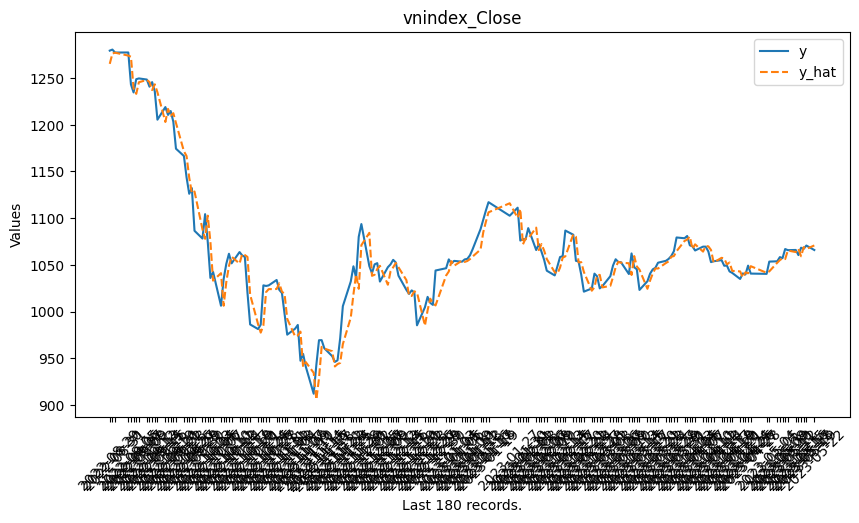

In [22]:
BiLSTM_multi2uni_manager.plot(multi2uni_loader.list_days[(index-ele):index],
                            y=inverse.inverse_transform(multi2uni_loader.y_test.reshape(-1, multi2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(BiLSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).reshape(-1, multi2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=multi2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)